# Naive Bayes for Amazon Reviews Dataset

In [1]:
#import libraries.....
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from nltk.corpus import stopwords
import nltk
import time
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
import datetime
from sklearn.naive_bayes import MultinomialNB
import sklearn.metrics
import tqdm
from prettytable import PrettyTable

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
# using the SQLite Table to read data.
# The below SQlite file consists of 60000 rows with Time based splitting and Summary column preprocessed[Feature Engineering].
con = sqlite3.connect('./final_tbs_cleansummary_text.sqlite')

final_tbs=pd.read_sql_query("""select * from Reviews""",con) # The table was preprocessed with time based splitting.
con.close()

final_tbs.head(5)

,level_0,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,Cleaned_Summary
0,0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,everi book educ
1,30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...,whole seri great way spend time child
2,424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...,entertainingl funni
3,330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...,modern day fairi tale
4,423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...,fantast


In [3]:
def partition(x):
    if x == "positive":
        return 1
    return 0

actualScore = final_tbs['Score']
positiveNegative = actualScore.map(partition) 
final_tbs['Score'] = positiveNegative

print(final_tbs['Score'].value_counts())

final_tbs.head(5)


1    51127
0     8873
Name: Score, dtype: int64


,level_0,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,Cleaned_Summary
0,0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,everi book educ
1,30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...,whole seri great way spend time child
2,424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...,entertainingl funni
3,330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...,modern day fairi tale
4,423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...,fantast


In [4]:
#Since Summary column gives move details about what the text is, I joined both the features[Feature Engineering].
final_tbs['Summary_CleanedText'] = final_tbs[['Cleaned_Summary', 'CleanedText']].apply(lambda x: ' '.join(x), axis=1)

print(final_tbs['Summary_CleanedText'][0])

everi book educ witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg


### Multinomial Naive Bayes:
MultinomialNB implements the naive Bayes algorithm for multinomially distributed data, and is one of the two classic naive Bayes variants used in text classification (where the data are typically represented as word vector counts, although tf-idf vectors are also known to work well in practice).

In [5]:
# split the data set into train and test
y = np.array(final_tbs['Score'])

In [6]:
#Splitting whole data into Train,Cv,and Test datasets
X_1, test_df, y_1, y_test = train_test_split(final_tbs, y, test_size=0.20, random_state=43,shuffle=False)

train_df, cv_df, y_tr, y_cv = train_test_split(X_1, y_1, test_size=0.20,random_state=43,shuffle=False)

In [7]:
def plot_confusion_matrix(y_test, pred):
    C = confusion_matrix(y_test, pred)
    
    labels = [1,2]
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(10,4))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
#tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
#print("True Negative Rate: ", tn/(tn+fp))
#print("True Positive Rate: ", tp/(fn+tp))
#print("False Positive Rate: ", fp/(tn+fp))
#print("False Negative Rate: ", fn/(fn+tp))


In [41]:
def NB_Classifier(train_std_data,cv_std_data,test_std_data,y_tr,y_cv,y_test):
    
    start=time.time()
    alpha_values = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
    cv_scores=[]
    for alpha in alpha_values:
        clf = MultinomialNB(alpha=alpha) 
        #scores = cross_val_score(clf, X_1, y_1, cv=10,scoring="accuracy")
        clf.fit(train_std_data, y_tr)      
        pred=clf.predict(cv_std_data)       
        f1 = metrics.f1_score(y_cv,pred)
        cv_scores.append(f1)
        
    # MSE = [1-x for x in cv_scores] # Misclassification error
    print(cv_scores)
    optimal_alpha = alpha_values[cv_scores.index(max(cv_scores))]
    print('\nThe optimal number of alpha is %f.' % optimal_alpha)
    
    # plot misclassification error vs k 
    plt.plot(alpha_values, cv_scores)
    
    for xy in zip(alpha_values, np.round(cv_scores,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    
    plt.xlabel('Hyperparameters')
    plt.ylabel('cv_scores')
    plt.show()
    
    print("the cv_scores for each alpha value is : ", np.round(cv_scores,3))
    
    Nb_optimal = MultinomialNB(alpha=optimal_alpha)
    
    # fitting the model
    Nb_optimal.fit(train_std_data, y_tr)   
    
    # predict the response
    pred = Nb_optimal.predict(test_std_data)
    
    print("----"*20)
    
    # Plotting Confusion_Matrix
    plot_confusion_matrix(y_test, pred)
    
    # evaluate accuracy
    acc = accuracy_score(y_test, pred) * 100
    print('\nThe accuracy of the NB classifier[Test data] for alpha = %d is %f%%' % (optimal_alpha, acc))
    
    # Precision
    precision = metrics.precision_score(y_test, pred)*100
    print('\nThe precision of the NB classifier[Test data] for alpha = %d is %f%%' % (optimal_alpha, precision))
    
    # Recall
    recall = metrics.recall_score(y_test, pred)*100
    print('\nThe recall of the NB classifier[Test data] for alpha = %d is %f%%' % (optimal_alpha, recall))
    
    #F1_Score
    f1_score = metrics.f1_score(y_test, pred)*100
    print('\nThe F1_score of the NB classifier[Test data] for alpha = %d is %f%%' % (optimal_alpha, f1_score))
    
    print("----"*20)
    
    end=time.time()-start
    print(time.strftime("%H:%M:%S", time.gmtime(end)))
    return Nb_optimal
    

### BOW

In [42]:
#BoW
count_vect = CountVectorizer(min_df=50,max_features=2000) #in scikit-learn

train_bows = count_vect.fit_transform(train_df['Summary_CleanedText'])
cv_bows = count_vect.transform(cv_df['Summary_CleanedText'])
test_bows = count_vect.transform(test_df['Summary_CleanedText'])

train_std_bow = StandardScaler(with_mean=False).fit_transform(train_bows)
cv_std_bow = StandardScaler(with_mean=False).fit_transform(cv_bows)
test_std_bow = StandardScaler(with_mean=False).fit_transform(test_bows)

[0.9041222178322139, 0.9041222178322139, 0.9041222178322139, 0.9041943767696055, 0.9042882550556617, 0.9032811777909817, 0.9016436903499471, 0.9178021420875847]

The optimal number of alpha is 1000.000000.


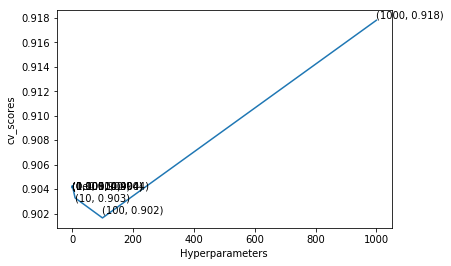

the cv_scores for each alpha value is :  [0.904 0.904 0.904 0.904 0.904 0.903 0.902 0.918]
--------------------------------------------------------------------------------
-------------------- Confusion matrix --------------------


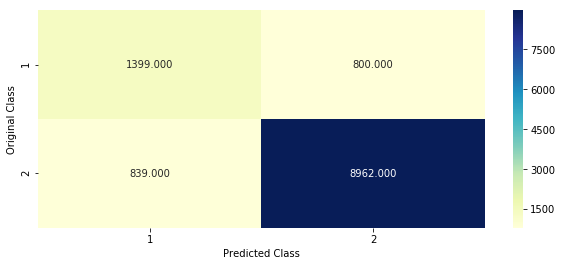


The accuracy of the NB classifier[Test data] for alpha = 1000 is 86.341667%

The precision of the NB classifier[Test data] for alpha = 1000 is 91.804958%

The recall of the NB classifier[Test data] for alpha = 1000 is 91.439649%

The F1_score of the NB classifier[Test data] for alpha = 1000 is 91.621939%
--------------------------------------------------------------------------------
00:00:00


In [43]:
clf = NB_Classifier(train_std_bow,cv_std_bow,test_std_bow,y_tr,y_cv,y_test) #calling function inorder to avoid duplicate code.

In [44]:
# To print top 10 features
'''
def print_top10(vectorizer, clf, class_labels):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
   # print(feature_names)
   # print(feature_names)
   # for class_label in range(class_labels):
    top10 = np.argsort(clf.coef_[0])[-10:]
    print("%s: %s" % (class_labels,
              " ".join(feature_names[j] for j in top10)))
        
#print("dimensionality: %d" % clf.coef_.shape[1])

print_top10(count_vect,clf,y[1])
'''

'\ndef print_top10(vectorizer, clf, class_labels):\n    """Prints features with the highest coefficient values, per class"""\n    feature_names = vectorizer.get_feature_names()\n   # print(feature_names)\n   # print(feature_names)\n   # for class_label in range(class_labels):\n    top10 = np.argsort(clf.coef_[0])[-10:]\n    print("%s: %s" % (class_labels,\n              " ".join(feature_names[j] for j in top10)))\n        \n#print("dimensionality: %d" % clf.coef_.shape[1])\n\nprint_top10(count_vect,clf,y[1])\n'

In [45]:
print("********************NEGATIVE****************************************************")

def show_most_informative_features(vectorizer, clf, n=10):
    feature_names = vectorizer.get_feature_names()
    #print(sorted(clf.coef_[0]))
    coefs_with_fns = sorted(zip(clf.feature_log_prob_[0], feature_names))
    #print(coefs_with_fns[:-11:-1])
    #top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    top = coefs_with_fns[:-(n + 1):-1]
    for (coef_1, fn_1) in top:
        print("\t%.4f\t%-15s\t" % (coef_1, fn_1))
        
show_most_informative_features(count_vect, clf, 10)
              
print("**********************POSITIVE*****************************************************")
              
def show_most_informative_features(vectorizer, clf, n=10):
    feature_names = vectorizer.get_feature_names()
    #print(sorted(clf.coef_[0]))
    coefs_with_fns = sorted(zip(clf.feature_log_prob_[1], feature_names))
    #print(coefs_with_fns[:-11:-1])
    #top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    top = coefs_with_fns[:-(n + 1):-1]
    for (coef_1, fn_1) in top:
        print("\t%.4f\t%-15s\t" % (coef_1, fn_1))
        
show_most_informative_features(count_vect, clf)

********************NEGATIVE****************************************************
	-6.4904	disappoint     	
	-6.4907	tast           	
	-6.5103	product        	
	-6.5361	like           	
	-6.6139	would          	
	-6.6528	bad            	
	-6.6874	buy            	
	-6.6966	money          	
	-6.7208	one            	
	-6.7332	dont           	
**********************POSITIVE*****************************************************
	-5.8474	great          	
	-5.9726	good           	
	-5.9880	love           	
	-6.0853	like           	
	-6.0994	tast           	
	-6.1573	best           	
	-6.2110	make           	
	-6.2146	one            	
	-6.2186	use            	
	-6.2241	tri            	


In [46]:
neg_class_prob_sorted = clf.feature_log_prob_[0, :].argsort()
pos_class_prob_sorted = clf.feature_log_prob_[1, :].argsort()

print(np.take(count_vect.get_feature_names(), neg_class_prob_sorted[:30]))
print(np.take(count_vect.get_feature_names(), pos_class_prob_sorted[:30]))

['smile' 'muesli' 'versatil' 'bedtim' 'immun' 'downsid' 'cardamom' 'ahmad'
 'superb' 'yum' 'camp' 'british' 'mood' 'aromat' 'hook' 'purs' 'juici'
 'ham' 'sooth' 'chipotl' 'rebecca' 'hearti' 'vacat' 'yorkshir' 'tortilla'
 'virgin' 'anytim' 'skeptic' 'cider' 'quinoa']
['yuck' 'mislead' 'rancid' 'refund' 'worst' 'zico' 'gelatin' 'bug'
 'disgust' 'omega' 'mold' 'marzipan' 'granul' 'threw' 'pearl' 'tasteless'
 'greeni' 'tran' 'brewer' 'rabbit' 'buckwheat' 'studi' 'crab' 'pellet'
 'immun' 'canida' 'mate' 'carpet' 'unpleas' 'garbag']


### TFIDF

In [54]:
tf_idf_vect = TfidfVectorizer(min_df=50,max_features=2000,ngram_range=(1, 3))

train_tfidf = tf_idf_vect.fit_transform(train_df['Summary_CleanedText'])
cv_tfidf = tf_idf_vect.transform(cv_df['Summary_CleanedText'])
test_tfidf = tf_idf_vect.transform(test_df['Summary_CleanedText'])

train_std_tfidf = StandardScaler(with_mean=False).fit_transform(train_tfidf)
cv_std_tfidf = StandardScaler(with_mean=False).fit_transform(cv_tfidf)
test_std_tfidf = StandardScaler(with_mean=False).fit_transform(test_tfidf)

[0.903976592631999, 0.903976592631999, 0.903976592631999, 0.9037578982374459, 0.9035391165513571, 0.9030452455520758, 0.8946410515672396, 0.9083425883582675]

The optimal number of alpha is 1000.000000.


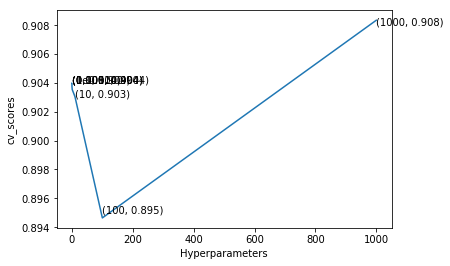

the cv_scores for each alpha value is :  [0.904 0.904 0.904 0.904 0.904 0.903 0.895 0.908]
--------------------------------------------------------------------------------
-------------------- Confusion matrix --------------------


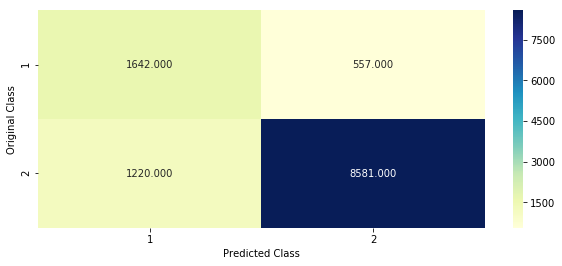


The accuracy of the NB classifier[Test data] for alpha = 1000 is 85.191667%

The precision of the NB classifier[Test data] for alpha = 1000 is 93.904574%

The recall of the NB classifier[Test data] for alpha = 1000 is 87.552291%

The F1_score of the NB classifier[Test data] for alpha = 1000 is 90.617245%
--------------------------------------------------------------------------------
00:00:00


In [55]:
clf = NB_Classifier(train_std_tfidf,cv_std_tfidf,test_std_tfidf,y_tr,y_cv,y_test) #calling function inorder to avoid duplicate code.

In [57]:
#print(y[467])

print("********************NEGATIVE****************************************************")

def show_most_informative_features(vectorizer, clf, n=30):
    feature_names = vectorizer.get_feature_names()
    #print(sorted(clf.coef_[0]))
    coefs_with_fns = sorted(zip(clf.feature_log_prob_[0], feature_names))
    #print(coefs_with_fns[:-11:-1])
    #top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    top = coefs_with_fns[:-(n + 1):-1]
    for (coef_1, fn_1) in top:
        print("\t%.4f %-15s\t" % (coef_1, fn_1))
        
show_most_informative_features(tf_idf_vect, clf)

print("**********************POSITIVE*****************************************************")

def show_most_informative_features(vectorizer, clf, n=30):
    feature_names = vectorizer.get_feature_names()
    #print(sorted(clf.coef_[0]))
    coefs_with_fns = sorted(zip(clf.feature_log_prob_[1], feature_names))
    #print(coefs_with_fns[:-11:-1])
    #top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    top = coefs_with_fns[:-(n + 1):-1]
    for i,(coef_1, fn_1) in enumerate(top):
        print("\t%.4f\t%-15s\t" %(coef_1, fn_1))
        
show_most_informative_features(tf_idf_vect, clf)

********************NEGATIVE****************************************************
	-6.4369 tast           	
	-6.4927 like           	
	-6.4941 disappoint     	
	-6.5642 product        	
	-6.5830 would          	
	-6.6648 bad            	
	-6.6799 dont           	
	-6.6959 money          	
	-6.7112 one            	
	-6.7358 wast           	
	-6.7397 buy            	
	-6.7473 horribl        	
	-6.7536 wast money     	
	-6.7670 terribl        	
	-6.7741 aw             	
	-6.7903 tri            	
	-6.7907 worst          	
	-6.7929 didnt          	
	-6.8004 order          	
	-6.8367 even           	
	-6.8477 box            	
	-6.8575 tast like      	
	-6.8601 thought        	
	-6.8753 look           	
	-6.8755 away           	
	-6.8829 review         	
	-6.8843 get            	
	-6.8858 much           	
	-6.8991 flavor         	
	-6.9020 receiv         	
**********************POSITIVE*****************************************************
	-5.9323	great          	
	-6.0332	love           	
	-6

## Conclusion:
    

In [58]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer","Hyperparameter", "Algorithm", "Accuracy", "Precision", "Recall", "F1_Score"]

x.add_row(["BOW", 1000, "NB", 86.34, 91.80, 91.43, 91.62])
x.add_row(["TFIDF", 1000, "NB", 85.19, 93.90, 87.55, 90.61])

print(x)

+------------+----------------+-----------+----------+-----------+--------+----------+
| Vectorizer | Hyperparameter | Algorithm | Accuracy | Precision | Recall | F1_Score |
+------------+----------------+-----------+----------+-----------+--------+----------+
|    BOW     |      1000      |     NB    |  86.34   |    91.8   | 91.43  |  91.62   |
|   TFIDF    |      1000      |     NB    |  85.19   |    93.9   | 87.55  |  90.61   |
+------------+----------------+-----------+----------+-----------+--------+----------+
